In [119]:
import os
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import warnings
# Suppress sklearn deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [120]:
def get_structure_path(tp):
    return os.path.join(base_dir, tp, condition, f"structure_{tp}_{condition}_gene_info.csv")

def load_gene_positions(file_path):
    df = pd.read_csv(file_path)
    return df[['gene_name', 'middle_x', 'middle_y', 'middle_z']].dropna()

# √N estimator kept for optional use
def estimate_min_cluster_size(coords):
    return max(5, int(np.sqrt(len(coords))))

def select_best_min_cluster_size(coords, min_val=5, max_val=50, step=5):
    best_score = -1
    best_size = min_val

    for size in range(min_val, max_val + 1, step):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        labels = clusterer.fit_predict(coords)

        # skip bad results
        if len(set(labels)) <= 1 or np.all(labels == -1):
            continue

        try:
            score = silhouette_score(coords, labels)
            if score > best_score:
                best_score = score
                best_size = size
        except:
            continue

    return best_size

def plot_3d_clusters(coords, labels, title=None):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab20', len(unique_labels))

    for i, label in enumerate(unique_labels):
        idx = labels == label
        ax.scatter(coords[idx, 0], coords[idx, 1], coords[idx, 2],
                   s=10, label=f"Cluster {label}" if label != -1 else "Noise",
                   color=colors(i), alpha=0.7)

    ax.set_title(title or "3D HDBSCAN Clusters")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0))
    plt.tight_layout()
    plt.show()

In [126]:
base_dir = "data/green_monkey/all_structure_files/"
condition = "vacv"
for chrom in os.listdir(base_dir):
    chrom_path = os.path.join(base_dir, chrom)
    if not os.path.isdir(chrom_path):
        continue
    print(f"Processing {chrom}...")
    results = []
    for hrs in os.listdir(chrom_path):
        hrs_path = os.path.join(chrom_path, hrs)
        if not os.path.isdir(hrs_path):
            continue
        cond_path = os.path.join(hrs_path, condition)
        if not os.path.isdir(cond_path):
            continue
        print(f"{cond_path}/structure_{hrs}_{condition}_gene_info.csv")
        df = load_gene_positions(f"{cond_path}/structure_{hrs}_{condition}_gene_info.csv")
    
        coords = df[['middle_x', 'middle_y', 'middle_z']].values
        genes = df['gene_name'].tolist()
    
        # Select best min_cluster_size using silhouette
        best_size = select_best_min_cluster_size(coords, min_val=5, max_val=55, step=1)
        print(f"{tp}: Best min_cluster_size (silhouette) = {best_size}")
    
        # Run HDBSCAN with best size
        clusterer = hdbscan.HDBSCAN(min_cluster_size=best_size)
        labels = clusterer.fit_predict(coords)
    
        # Visualize clusters
        # plot_3d_clusters(coords, labels, title=f"{tp} - HDBSCAN Clusters")
    
        for gene, label, (x, y, z) in zip(genes, labels, coords):
            results.append({
                'chromosome': chrom,
                'timepoint': tp,
                'gene_name': gene,
                'middle_x': x,
                'middle_y': y,
                'middle_z': z,
                'cluster': label
            })

    # Combine and save
    cluster_df = pd.DataFrame(results)
    cluster_df.to_csv(f"{base_dir}{chrom}/spatial_data/{chrom}_vacv_spatial_clusters_hdbscan.csv", index=False)


Processing chr23...
data/green_monkey/all_structure_files/chr23/24hrs/vacv/structure_24hrs_vacv_gene_info.csv
24hrs: Best min_cluster_size (silhouette) = 20
data/green_monkey/all_structure_files/chr23/12hrs/vacv/structure_12hrs_vacv_gene_info.csv
24hrs: Best min_cluster_size (silhouette) = 15
data/green_monkey/all_structure_files/chr23/18hrs/vacv/structure_18hrs_vacv_gene_info.csv
24hrs: Best min_cluster_size (silhouette) = 15
Processing chr12...
data/green_monkey/all_structure_files/chr12/24hrs/vacv/structure_24hrs_vacv_gene_info.csv
24hrs: Best min_cluster_size (silhouette) = 16
data/green_monkey/all_structure_files/chr12/12hrs/vacv/structure_12hrs_vacv_gene_info.csv
24hrs: Best min_cluster_size (silhouette) = 33
data/green_monkey/all_structure_files/chr12/18hrs/vacv/structure_18hrs_vacv_gene_info.csv
24hrs: Best min_cluster_size (silhouette) = 54
Processing chr15...
data/green_monkey/all_structure_files/chr15/24hrs/vacv/structure_24hrs_vacv_gene_info.csv
24hrs: Best min_cluster_size

In [112]:
cluster_df

,timepoint,gene_name,cluster
0,12hrs,SCGB1C1,-1
1,12hrs,ODF3,-1
2,12hrs,BET1L,0
3,12hrs,RIC8A,0
4,12hrs,SIRT3,0
...,...,...,...
5788,24hrs,LOC103248902,-1
5789,24hrs,LOC103248901,-1
5790,24hrs,LOC103248904,-1
5791,24hrs,LOC103248905,-1


In [113]:
cluster_counts = cluster_df.groupby("timepoint")["cluster"].nunique()
print("Communities per timepoint:\n", cluster_counts)


Communities per timepoint:
 timepoint
12hrs    11
18hrs     3
24hrs     4
Name: cluster, dtype: int64


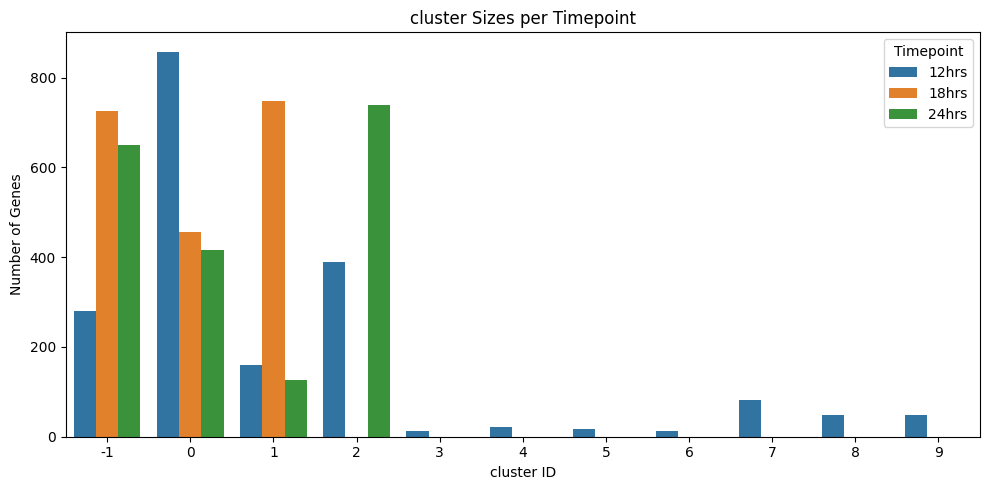

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=cluster_df, x="cluster", hue="timepoint")
plt.title("cluster Sizes per Timepoint")
plt.xlabel("cluster ID")
plt.ylabel("Number of Genes")
plt.legend(title="Timepoint")
plt.tight_layout()
plt.show()


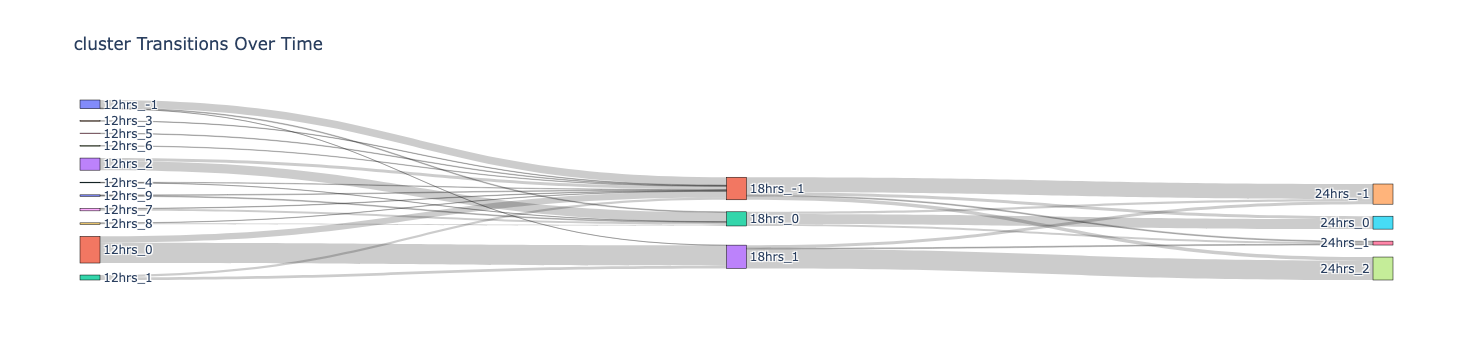

In [115]:
pivot = cluster_df.pivot(index='gene_name', columns='timepoint', values='cluster')
pivot = pivot.dropna()  # remove genes missing at any timepoint

from collections import Counter

# Get timepoints in order
timepoints = pivot.columns.tolist()

# Build transitions between consecutive timepoints
transitions = []

for i in range(len(timepoints) - 1):
    src_tp = timepoints[i]
    tgt_tp = timepoints[i + 1]

    src = pivot[src_tp].astype(str)
    tgt = pivot[tgt_tp].astype(str)
    
    pairs = list(zip([f"{src_tp}_{s}" for s in src], [f"{tgt_tp}_{t}" for t in tgt]))
    transitions.extend(pairs)

transition_counts = Counter(transitions)

import plotly.graph_objects as go

# Build list of unique labels
labels = sorted(set([src for src, _ in transition_counts] + [tgt for _, tgt in transition_counts]))
label_idx = {label: i for i, label in enumerate(labels)}

# Source, target, and value lists
sources = [label_idx[src] for src, tgt in transition_counts]
targets = [label_idx[tgt] for src, tgt in transition_counts]
values = list(transition_counts.values())

# Create Sankey plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

fig.update_layout(title_text="cluster Transitions Over Time", font_size=12)
fig.show()
